
[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Dataset Loaded. First 5 rows:
    IDCNTRY  IDPOP  IDGRADER  IDGRADE  WAVE  IDSCHOOL   IDCLASS      IDSTUD  \
0   7106.0    1.0       2.0      6.0   2.0    5001.0  500101.0  50010101.0   
1   7106.0    1.0       2.0      6.0   2.0    5001.0  500101.0  50010102.0   
2   7106.0    1.0       2.0      6.0   2.0    5001.0  500101.0  50010103.0   
3   7106.0    1.0       2.0      6.0   2.0    5001.0  500101.0  50010104.0   
4   7106.0    1.0       2.0      6.0   2.0    5001.0  500101.0  50010106.0   

    IDTEACH  IDLINK  ...  ACBG21E  ACBG21F  ACBGRRS  ACDGRRS  ACBGEAS  \
0  500101.0     1.0  ...      NaN      NaN      NaN      NaN      NaN   
1  500101.0     1.0  ...      NaN      NaN      NaN      NaN      NaN   
2  500101.0     1.0  ...      NaN      NaN      NaN      NaN      NaN   
3  500101.0     1.0  ...    

/var/folders/dh/xqpps4x912sbfxqjxd8_xgbm0000gn/T/ipykernel_34767/3122445786.py:59: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  desc_stats = df.groupby(['SES_Label', 'ParentalInv_Collapsed', 'ReadAtt_Label'])['ASRREA01'].agg(['mean', 'std', 'count'])


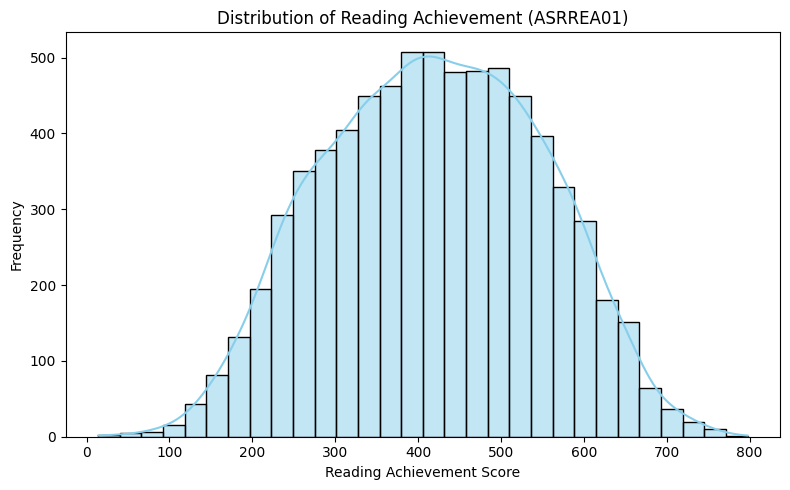

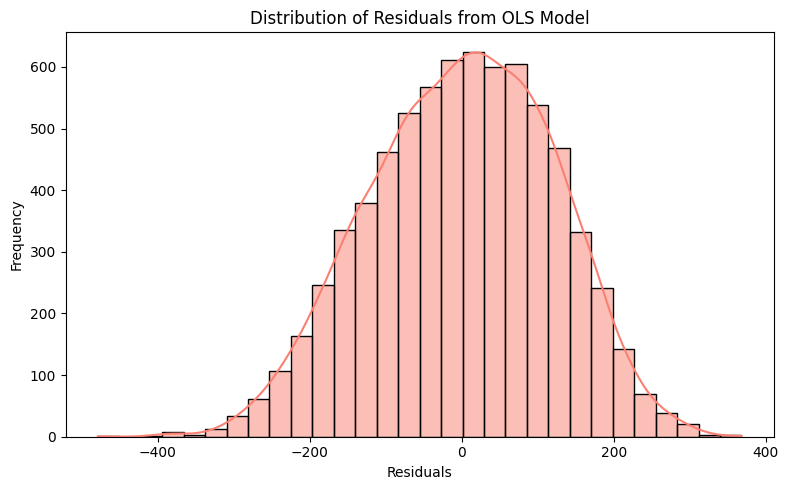

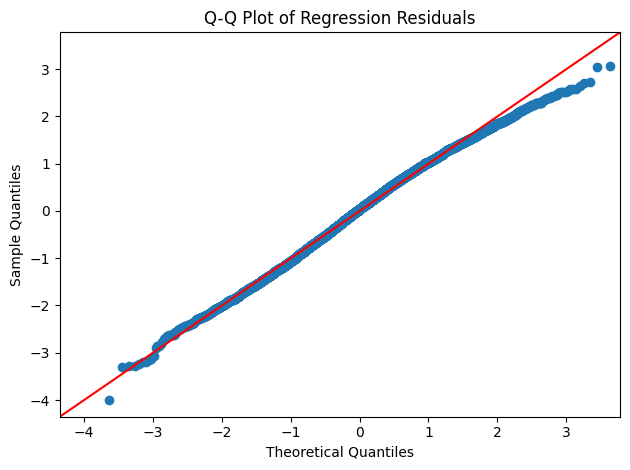

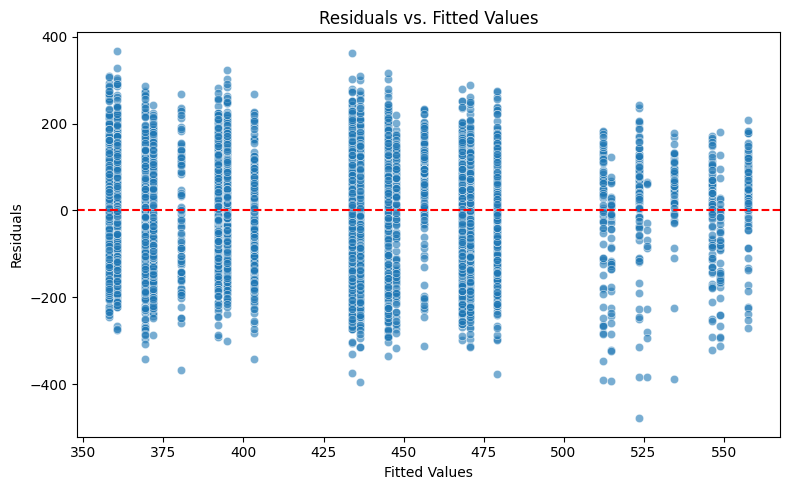

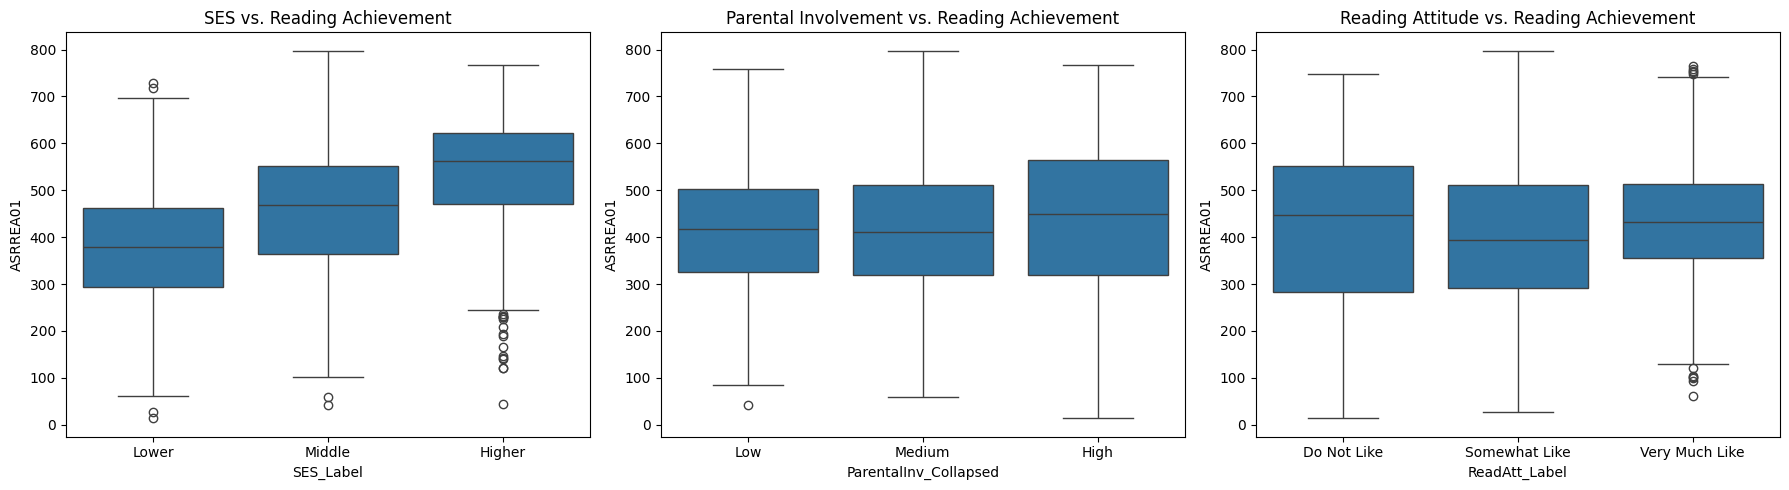

In [2]:
# Install necessary packages (only run once)
%pip install statsmodels matplotlib seaborn

# Import libraries
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

# Load dataset
file_path = "/Users/johnbaffoe/Desktop/SOUTH AFRICA/SOUTHSOUTH.csv"  # Update this path if needed
df = pd.read_csv(file_path)

# Display the first 5 rows
print("Dataset Loaded. First 5 rows:\n", df.head())

# ------- Recode Categorical Variables Properly ---------

# Recode SES
df['SES_Label'] = df['ASDHSES'].replace({
    3.0: 'Lower',   # 3 = Lower SES
    2.0: 'Middle',  # 2 = Middle SES
    1.0: 'Higher'   # 1 = Higher SES
})

# Recode Reading Attitude
df['ReadAtt_Label'] = df['ASDGSLR'].replace({
    3.0: 'Do Not Like',
    2.0: 'Somewhat Like',
    1.0: 'Very Much Like'
})

# Collapse Parental Involvement
df['ParentalInv_Collapsed'] = df['ACBG11F'].replace({
    1.0: 'High',   # Very High
    2.0: 'High',   # High
    3.0: 'Medium', # Medium
    4.0: 'Low',    # Low
    5.0: 'Low'     # Very Low
})

# Convert to ordered categorical types
df['SES_Label'] = pd.Categorical(df['SES_Label'], categories=['Lower', 'Middle', 'Higher'], ordered=True)
df['ParentalInv_Collapsed'] = pd.Categorical(df['ParentalInv_Collapsed'], categories=['Low', 'Medium', 'High'], ordered=True)
df['ReadAtt_Label'] = pd.Categorical(df['ReadAtt_Label'], categories=['Do Not Like', 'Somewhat Like', 'Very Much Like'], ordered=True)

# Subset relevant columns
df = df[['SES_Label', 'ParentalInv_Collapsed', 'ReadAtt_Label', 'ASRREA01']]

# Drop missing values
print("Original dataset size:", df.shape)
df = df.dropna()
print("After dropping NAs:", df.shape)

# ----------- Descriptive Statistics -------------
desc_stats = df.groupby(['SES_Label', 'ParentalInv_Collapsed', 'ReadAtt_Label'])['ASRREA01'].agg(['mean', 'std', 'count'])
print("\nDescriptive Statistics:\n", desc_stats)

# ----------- Dummy Coding for Regression -----------

# Create dummy variables (drop_first=True to set reference group)
df_dummies = pd.get_dummies(df, columns=['SES_Label', 'ParentalInv_Collapsed', 'ReadAtt_Label'], drop_first=True)

# Define X (predictors) and y (outcome)
X = df_dummies.drop(columns='ASRREA01')
X = sm.add_constant(X)  # Add constant (intercept)
y = df_dummies['ASRREA01']

# Ensure numeric
X = X.astype(float)
y = y.astype(float)

# Align X and y
X = X.dropna()
y = y.loc[X.index]

# ----------- Fit OLS Regression -------------
model = sm.OLS(y, X).fit()

# Breusch-Pagan Test
bp_test = het_breuschpagan(model.resid, model.model.exog)
bp_labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print("\nBreusch-Pagan Test for Homoscedasticity:")
for name, val in zip(bp_labels, bp_test):
    print(f"{name}: {val:.4f}")

# Robust model
robust_model = model.get_robustcov_results(cov_type='HC3')
print(robust_model.summary())

# VIF for multicollinearity
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print("\nVariance Inflation Factor (VIF):\n", vif_data)

# OLS Regression Summary
print("\nOLS Regression Summary:\n", model.summary())

# ----------- T-Tests ---------------
def ttest_by_category(var):
    levels = df[var].cat.categories
    group1 = df[df[var] == levels[0]]['ASRREA01']
    group2 = df[df[var] == levels[-1]]['ASRREA01']
    t_stat, p_val = stats.ttest_ind(group1, group2, equal_var=False)
    print(f"\nT-test for {var}: t-statistic = {t_stat:.3f}, p-value = {p_val:.3f}")

ttest_by_category('SES_Label')
ttest_by_category('ParentalInv_Collapsed')
ttest_by_category('ReadAtt_Label')

# ----------- Plots ----------------

# Plot 1: Histogram of Reading Achievement
plt.figure(figsize=(8, 5))
sns.histplot(df['ASRREA01'], kde=True, bins=30, color='skyblue')
plt.title("Distribution of Reading Achievement (ASRREA01)")
plt.xlabel("Reading Achievement Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot 2: Histogram of Residuals
residuals = model.resid
plt.figure(figsize=(8, 5))
sns.histplot(residuals, kde=True, bins=30, color='salmon')
plt.title("Distribution of Residuals from OLS Model")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# Plot 3: Q-Q Plot of Residuals
sm.qqplot(residuals, line='45', fit=True)
plt.title("Q-Q Plot of Regression Residuals")
plt.tight_layout()
plt.show()

# Plot 4: Residuals vs. Fitted Values
fitted_vals = model.fittedvalues
plt.figure(figsize=(8, 5))
sns.scatterplot(x=fitted_vals, y=residuals, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title("Residuals vs. Fitted Values")
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.tight_layout()
plt.show()

# Plot 5: Boxplots by Categorical Variables
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.boxplot(ax=axes[0], x='SES_Label', y='ASRREA01', data=df)
axes[0].set_title("SES vs. Reading Achievement")

sns.boxplot(ax=axes[1], x='ParentalInv_Collapsed', y='ASRREA01', data=df)
axes[1].set_title("Parental Involvement vs. Reading Achievement")

sns.boxplot(ax=axes[2], x='ReadAtt_Label', y='ASRREA01', data=df)
axes[2].set_title("Reading Attitude vs. Reading Achievement")

plt.tight_layout()
plt.show()
